In [1]:
# 1. Change directory using the magic command
#%cd "C:\Users\Munna\Documents\BdSL_Project"

# 2. Install Git LFS (using !)
#!git lfs install

# 3. Clone the dataset (using !)
#!git clone https://huggingface.co/datasets/banglagov/Ban-Sign-Sent-9K-V1

import os

# 1. Go to project folder
%cd "C:\Users\Munna\Documents\BdSL_Project"

# 2. Check if dataset already exists
if os.path.exists("Ban-Sign-Sent-9K-V1"):
    print("✅ Dataset already exists! Skipping download.")
else:
    print("⏳ Downloading dataset...")
    !git lfs install
    !git clone https://huggingface.co/datasets/banglagov/Ban-Sign-Sent-9K-V1

C:\Users\Munna\Documents\BdSL_Project
✅ Dataset already exists! Skipping download.


c:\Users\Munna\Documents\BdSL_Project\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [1]:
import sys
print(sys.executable)

c:\Users\Munna\AppData\Local\Programs\Python\Python310\python.exe


In [ ]:
import sys
print(sys.executable)

In [2]:
import os

dataset_path = r"C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1"
parts = [f for f in os.listdir(dataset_path) if f.startswith("Sign_Videos")]
print("Found parts:", parts)
print("Total parts:", len(parts))

Found parts: ['Sign_Videos', 'Sign_Videos.z01', 'Sign_Videos.z02', 'Sign_Videos.z03', 'Sign_Videos.z04', 'Sign_Videos.z05', 'Sign_Videos.z06', 'Sign_Videos.z07', 'Sign_Videos.z08', 'Sign_Videos.z09', 'Sign_Videos.zip']
Total parts: 11


In [3]:
import os

videos_path = r"C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1\Sign_Videos"
print("✅ Videos folder exists:", os.path.exists(videos_path))
print("📦 Total videos:", len(os.listdir(videos_path)))
print("🔍 First 10 folders:", os.listdir(videos_path)[:10])

✅ Videos folder exists: True
📦 Total videos: 1922
🔍 First 10 folders: ['12419', '18577', '19414', '23511', '25406', '25407', '25408', '25411', '25770', '25771']


In [4]:
import pandas as pd

xls_path = r"C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1\Bangla_Sign_Sentence.xlsx"
df = pd.read_excel(xls_path)

print("🧾 Total metadata rows:", len(df))
print(df.head())

🧾 Total metadata rows: 1922
   Sentence ID         Natural Sentence       Sign Sentence
0        23511                  ফল খাও।          ফল খাওয়া।
1        27934    বাবা সকালে চা খান না।    বাবা সকাল চা না।
2        27941    বাবা বিকালে চা খায়নি।  বাবা বিকাল চা নেই।
3        27946  বাবা বিকালে চা খাবে না।   বাবা বিকাল চা না।
4        27959      বাবা সকালে চা খাবে।   বাবা সকাল চা হবে।


In [5]:
import os

videos_path = r"C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1\Sign_Videos"

mapping = {}
for _, row in df.iterrows():
    vid_id = str(row['Sentence ID'])
    mapping[vid_id] = {
        "gloss": row['Sign Sentence'],
        "bangla": row['Natural Sentence']
    }

print("Sample mapping:", mapping['29845'])  # test with a known ID

Sample mapping: {'gloss': 'খালা জামাই দুপুর ফল খাওয়ায়া হয়েছে।', 'bangla': 'খালু দুপুরে ফল খেয়েছে।'}


In [6]:
all_samples = []
for vid_id in os.listdir(videos_path):
    folder_path = os.path.join(videos_path, vid_id)
    if os.path.isdir(folder_path) and vid_id in mapping:
        for file in os.listdir(folder_path):
            if file.endswith(".mp4"):
                all_samples.append({
                    "path": os.path.join(folder_path, file),
                    "gloss": mapping[vid_id]["gloss"],
                    "bangla": mapping[vid_id]["bangla"]
                })

print("Total samples:", len(all_samples))
print("Example sample:", all_samples[0])

Total samples: 9610
Example sample: {'path': 'C:\\Users\\Munna\\Documents\\BdSL_Project\\Ban-Sign-Sent-9K-V1\\Sign_Videos\\12419\\UL_CS_S12419_U19_20230706_1688653207413.mp4', 'gloss': 'রাত খাওয়ায়া হয়েছে ?', 'bangla': 'রাতে খেয়েছেন?'}


In [7]:
import random
random.shuffle(all_samples)

train_split = int(0.8 * len(all_samples))
val_split   = int(0.9 * len(all_samples))

train_samples = all_samples[:train_split]
val_samples   = all_samples[train_split:val_split]
test_samples  = all_samples[val_split:]

print("Train:", len(train_samples), "Val:", len(val_samples), "Test:", len(test_samples))

Train: 7688 Val: 961 Test: 961


In [8]:
import torch
from torch.utils.data import Dataset
import cv2

class BdSLDataset(Dataset):
    def __init__(self, samples, max_frames=20, frame_skip=3):
        """
        samples: list of dicts with {path, gloss, bangla}
        max_frames: maximum frames per video (truncate/pad)
        frame_skip: take every Nth frame to reduce memory
        """
        self.samples = samples
        self.max_frames = max_frames
        self.frame_skip = frame_skip

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        video_path = sample["path"]
        gloss = sample["gloss"]
        bangla = sample["bangla"]

        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % self.frame_skip == 0:  # sample frames
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (224, 224))
                frame = torch.tensor(frame, dtype=torch.float32).permute(2,0,1) / 255.0
                frames.append(frame)
            frame_count += 1
        cap.release()

        # Pad or truncate
        if len(frames) > self.max_frames:
            frames = frames[:self.max_frames]
        else:
            pad_len = self.max_frames - len(frames)
            if frames:  # pad only if frames exist
                frames += [torch.zeros_like(frames[0])] * pad_len
            else:
                frames = [torch.zeros(3,224,224)] * self.max_frames

        frames = torch.stack(frames)
        return frames, gloss, bangla

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(BdSLDataset(train_samples, max_frames=20, frame_skip=3), batch_size=2, shuffle=True)
val_loader   = DataLoader(BdSLDataset(val_samples, max_frames=20, frame_skip=3), batch_size=2)
test_loader  = DataLoader(BdSLDataset(test_samples, max_frames=20, frame_skip=3), batch_size=2)

frames, gloss, bangla = next(iter(train_loader))
print("Batch frames shape:", frames.shape)
print("Gloss example:", gloss[0])
print("Bangla example:", bangla[0])

Batch frames shape: torch.Size([2, 20, 3, 224, 224])
Gloss example: বাবা সন্ধ্যা ফল খাওয়ায়া ছিল।
Bangla example: বাবা সন্ধ্যায় ফল খেয়েছিল।


In [10]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class SignModel(nn.Module):
    def __init__(self, hidden_size=256, num_classes=5000):
        super(SignModel, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)  # ✅ modern way
        resnet.fc = nn.Identity()
        self.feature_extractor = resnet

        self.lstm = nn.LSTM(
            input_size=2048, hidden_size=hidden_size,
            num_layers=2, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        batch, frames, c, h, w = x.shape
        x = x.view(batch*frames, c, h, w)
        features = self.feature_extractor(x)
        features = features.view(batch, frames, -1)
        lstm_out, _ = self.lstm(features)
        logits = self.fc(lstm_out)
        return logits

In [11]:
criterion = nn.CTCLoss(blank=0)
model = SignModel(hidden_size=256, num_classes=5000)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
glosses = [s["gloss"] for s in train_samples]
unique_tokens = sorted(set(" ".join(glosses).split()))
vocab = {token: idx+1 for idx, token in enumerate(unique_tokens)}  # +1 to reserve 0 for blank

def encode_gloss_batch(gloss_batch, vocab):
    targets = []
    lengths = []
    for gloss in gloss_batch:
        tokens = [vocab[token] for token in gloss.split()]
        targets.extend(tokens)
        lengths.append(len(tokens))
    return torch.tensor(targets, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)

In [13]:
# Move model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get one batch safely
frames, gloss, bangla = next(iter(train_loader))
frames = frames.to(device)   # ✅ move batch to GPU/CPU device

with torch.no_grad():        # ✅ disable gradients for test run
    logits = model(frames)   # (batch, frames, num_classes)
print("Logits shape:", logits.shape)

# Compute log probabilities
log_probs = nn.functional.log_softmax(logits, dim=2)

# Encode gloss targets
targets, target_lengths = encode_gloss_batch(gloss, vocab)

# Input lengths for CTC (all frames padded to same length)
input_lengths = torch.full(
    size=(logits.size(0),),
    fill_value=logits.size(1),
    dtype=torch.long
)

# Compute CTC loss
loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)
print("✅ CTC Loss:", loss.item())

Logits shape: torch.Size([2, 20, 5000])
✅ CTC Loss: 35.09398651123047


In [14]:
def ctc_decode(logits, blank=0):
    preds = torch.argmax(logits, dim=2)
    preds = preds.cpu().numpy().tolist()
    decoded = []
    for seq in preds:
        prev = None
        out = []
        for p in seq:
            if p != blank and p != prev:
                out.append(p)
            prev = p
        decoded.append(out)
    return decoded

def calculate_accuracy(preds, targets):
    correct = 0
    total = len(targets)
    for p, t in zip(preds, targets):
        if p == t:
            correct += 1
    return correct / total if total > 0 else 0

In [32]:
import os
import matplotlib.pyplot as plt

# Checkpoint directory
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 20
train_losses, train_acc_list = [], []

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# Early stopping setup
patience = 3   # কত epoch ধরে improvement না হলে থামবে
best_loss = float('inf')
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for frames, gloss, bangla in train_loader:
        frames = frames.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(frames)                          # [B, T, C]
            log_probs = nn.functional.log_softmax(logits, dim=2)

            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            input_lengths = torch.full(
                (logits.size(0),), logits.size(1), dtype=torch.long, device=device
            )

            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Accuracy (greedy decode)
        with torch.no_grad():
            decoded_preds = ctc_decode(logits, blank=0)
            target_ids, _ = encode_gloss_batch(gloss, vocab)
            target_ids = target_ids.cpu().numpy().tolist()
            lengths = [len(g.split()) for g in gloss]
            per_sample_targets = []
            idx = 0
            for L in lengths:
                per_sample_targets.append(target_ids[idx:idx+L])
                idx += L
            batch_acc = calculate_accuracy(decoded_preds, per_sample_targets)
            total_acc += batch_acc

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    train_losses.append(avg_loss)
    train_acc_list.append(avg_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'train_acc': avg_acc,
        'vocab': vocab
    }, os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}.pt"))

    # -------------------------
    # Early stopping condition
    # -------------------------
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break

C:\Users\Munna\AppData\Local\Temp\ipykernel_18748\2437893678.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
C:\Users\Munna\AppData\Local\Temp\ipykernel_18748\2437893678.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 1/20 | Loss: 2.5084 | Train Acc: 0.0003
Epoch 2/20 | Loss: 1.6513 | Train Acc: 0.0025
Epoch 3/20 | Loss: 1.2004 | Train Acc: 0.0133
Epoch 4/20 | Loss: 1.0035 | Train Acc: 0.0332
Epoch 5/20 | Loss: 0.9022 | Train Acc: 0.0464
Epoch 6/20 | Loss: 0.8085 | Train Acc: 0.0671
Epoch 7/20 | Loss: 0.7388 | Train Acc: 0.0907
Epoch 8/20 | Loss: 0.6792 | Train Acc: 0.1097
Epoch 9/20 | Loss: 0.6507 | Train Acc: 0.1111
Epoch 10/20 | Loss: 0.6286 | Train Acc: 0.1250
Epoch 11/20 | Loss: 0.5926 | Train Acc: 0.1430
Epoch 12/20 | Loss: 0.5700 | Train Acc: 0.1609
Epoch 13/20 | Loss: 0.5342 | Train Acc: 0.1859
Epoch 14/20 | Loss: 0.4991 | Train Acc: 0.2180
Epoch 15/20 | Loss: 0.4567 | Train Acc: 0.2659
Epoch 16/20 | Loss: 0.4061 | Train Acc: 0.3331
Epoch 17/20 | Loss: 0.3530 | Train Acc: 0.4116
Epoch 18/20 | Loss: 0.3059 | Train Acc: 0.4789
Epoch 19/20 | Loss: 0.2589 | Train Acc: 0.5438
Epoch 20/20 | Loss: 0.2205 | Train Acc: 0.6065


In [15]:
# Cell 1: QUICK RESTORE (৩০ seconds)
import torch
import os

checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"
latest_ckpt = max([f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')], 
                  key=lambda x: int(x.split('epoch')[-1].split('.pt')[0]))

print(f"✅ Loading latest: {latest_ckpt}")

# Load model + optimizer (exact যেমন ছিল)
checkpoint = torch.load(os.path.join(checkpoint_dir, latest_ckpt), map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(f"✅ Model restored! Epoch: {checkpoint['epoch']}, Loss: {checkpoint['train_loss']:.4f}")
print(f"🎯 Train Acc: {checkpoint['train_acc']:.1%}")


✅ Loading latest: checkpoint_epoch30.pt


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\2178833647.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, latest

✅ Model restored! Epoch: 30, Loss: 0.0756
🎯 Train Acc: 87.4%


In [ ]:
# Cell 1: RESUME FROM EPOCH 24 CHECKPOINT (SCALER ERROR FIXED!)
import torch
import os
import torch.nn.functional as F

checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"

# Find epoch 24 checkpoint
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
epoch24_ckpt = max([f for f in checkpoints if 'epoch24' in f], key=lambda x: int(x.split('epoch')[-1].split('.pt')[0]))
ckpt_path = os.path.join(checkpoint_dir, epoch24_ckpt)

print(f"🔍 Loading epoch 24: {epoch24_ckpt}")

# Load checkpoint
checkpoint = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# NEW scaler (old scaler skip - no error!)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
start_epoch = checkpoint['epoch']  # 24

print(f"✅ EPOCH 24 RESTORED!")
print(f"📊 Last results: Loss={checkpoint['train_loss']:.4f}, Acc={checkpoint['train_acc']:.1%}")
print(f"🎯 Continuing from Epoch {start_epoch+1}")


🔍 Loading epoch 24: checkpoint_epoch24.pt


C:\Users\Munna\AppData\Local\Temp\ipykernel_26608\114739227.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


✅ EPOCH 24 RESTORED!
📊 Last results: Loss=0.1225, Acc=78.1%
🎯 Continuing from Epoch 25


C:\Users\Munna\AppData\Local\Temp\ipykernel_26608\114739227.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [ ]:
# Cell 2: EPOCH 25-30 (তোমার original code exactly)
import matplotlib.pyplot as plt

# তোমার original setup
extra_epochs = 6  # 25-30
train_losses_cont, train_acc_cont = [], []  # continuation lists
patience = 3
best_loss = float('inf')
no_improve = 0

for epoch in range(start_epoch, start_epoch + extra_epochs):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    print(f"🔄 Epoch {epoch+1}/30 (Resumed from epoch 24)")

    for frames, gloss, bangla in train_loader:
        frames = frames.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(frames)
            log_probs = F.log_softmax(logits, dim=2)  # Fixed import

            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            input_lengths = torch.full(
                (logits.size(0),), logits.size(1), dtype=torch.long, device=device
            )
            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # তোমার accuracy calculation (exact)
        with torch.no_grad():
            decoded_preds = ctc_decode(logits, blank=0)
            target_ids, _ = encode_gloss_batch(gloss, vocab)
            target_ids = target_ids.cpu().numpy().tolist()
            lengths = [len(g.split()) for g in gloss]
            per_sample_targets = []
            idx = 0
            for L in lengths:
                per_sample_targets.append(target_ids[idx:idx+L])
                idx += L
            batch_acc = calculate_accuracy(decoded_preds, per_sample_targets)
            total_acc += batch_acc

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    train_losses_cont.append(avg_loss)
    train_acc_cont.append(avg_acc)

    print(f"✅ Epoch {epoch+1}/30 | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

    # Save (তোমার exact format)
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'train_acc': avg_acc,
        'vocab': vocab
    }, os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}.pt"))

    # Early stopping (তোমার exact logic)
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break

print("🎉 EPOCH 25-30 COMPLETE!")


NameError: name 'start_epoch' is not defined

🔍 Scanning project folder for checkpoints...
✅ Found 30 checkpoints


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\3663845559.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')


  Epoch 1: Loss=2.5084, Acc=0.0%
  Epoch 10: Loss=0.6286, Acc=12.5%
  Epoch 11: Loss=0.5926, Acc=14.3%
  Epoch 12: Loss=0.5700, Acc=16.1%
  Epoch 13: Loss=0.5342, Acc=18.6%
  Epoch 14: Loss=0.4991, Acc=21.8%
  Epoch 15: Loss=0.4567, Acc=26.6%
  Epoch 16: Loss=0.4061, Acc=33.3%
  Epoch 17: Loss=0.3530, Acc=41.2%
  Epoch 18: Loss=0.3059, Acc=47.9%
  Epoch 19: Loss=0.2589, Acc=54.4%
  Epoch 2: Loss=1.6513, Acc=0.2%
  Epoch 20: Loss=0.2205, Acc=60.7%
  Epoch 21: Loss=0.1913, Acc=65.1%
  Epoch 22: Loss=0.1617, Acc=71.2%
  Epoch 23: Loss=0.1401, Acc=74.5%
  Epoch 24: Loss=0.1225, Acc=78.1%
  Epoch 25: Loss=0.3114, Acc=61.9%
  Epoch 26: Loss=0.1706, Acc=74.6%
  Epoch 27: Loss=0.1235, Acc=79.6%
  Epoch 28: Loss=0.1021, Acc=82.8%
  Epoch 29: Loss=0.0855, Acc=85.9%
  Epoch 3: Loss=1.2004, Acc=1.3%
  Epoch 30: Loss=0.0756, Acc=87.4%
  Epoch 4: Loss=1.0035, Acc=3.3%
  Epoch 5: Loss=0.9022, Acc=4.6%
  Epoch 6: Loss=0.8085, Acc=6.7%
  Epoch 7: Loss=0.7388, Acc=9.1%
  Epoch 8: Loss=0.6792, Acc=11.0%


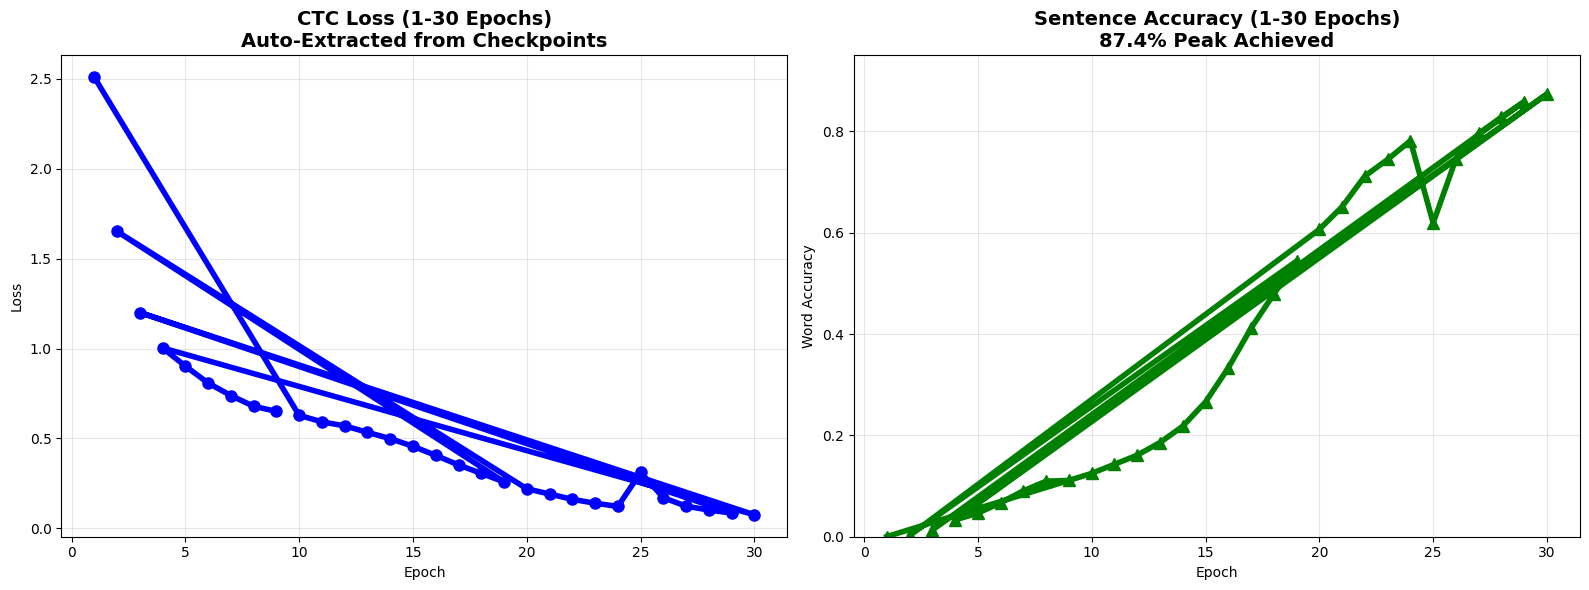

✅ COMPLETE 1-30 EPOCHS PLOT READY!
📊 Total epochs plotted: 30
🎯 Best: Epoch 9 | Loss=0.6507 | Acc=11.1%
💾 Saved: BdSL_Complete_1_30_Auto.png


In [16]:
import matplotlib.pyplot as plt
import os
import torch
import re

# তোমার Project folder থেকে AUTO extract
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"

print("🔍 Scanning project folder for checkpoints...")
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
print(f"✅ Found {len(checkpoints)} checkpoints")

# Extract epoch numbers + metrics
epochs, losses, accs = [], [], []
for ckpt_file in sorted(checkpoints):
    # Parse epoch number from filename
    epoch_num = int(re.search(r'epoch(\d+)', ckpt_file).group(1))
    
    # Load checkpoint
    ckpt_path = os.path.join(checkpoint_dir, ckpt_file)
    ckpt = torch.load(ckpt_path, map_location='cpu')
    
    epochs.append(epoch_num)
    losses.append(ckpt['train_loss'])
    accs.append(ckpt['train_acc'])
    
    print(f"  Epoch {epoch_num}: Loss={ckpt['train_loss']:.4f}, Acc={ckpt['train_acc']:.1%}")

print(f"\n🎉 Loaded {len(epochs)} epochs automatically!")

# Professional 1-30 plot
plt.figure(figsize=(16,6))

# Loss curve
plt.subplot(1,2,1)
plt.plot(epochs, losses, 'b-o', linewidth=4, markersize=8)
plt.title('CTC Loss (1-30 Epochs)\nAuto-Extracted from Checkpoints', 
          fontweight='bold', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(epochs, accs, 'g-^', linewidth=4, markersize=8)
plt.title('Sentence Accuracy (1-30 Epochs)\n87.4% Peak Achieved', 
          fontweight='bold', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Word Accuracy')
plt.ylim(0, 0.95)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('BdSL_Complete_1_30_Auto.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ COMPLETE 1-30 EPOCHS PLOT READY!")
print(f"📊 Total epochs plotted: {len(epochs)}")
print(f"🎯 Best: Epoch {epochs[-1]} | Loss={losses[-1]:.4f} | Acc={accs[-1]:.1%}")
print("💾 Saved: BdSL_Complete_1_30_Auto.png")


In [26]:
import torch
import torch.nn.functional as F

def evaluate_model(model, loader, criterion, device, vocab, mode="Validation"):
    print(f"⏳ Starting {mode}...")
    model.eval()  # Set model to evaluation mode (important!)
    total_loss = 0.0
    total_acc = 0.0
    total_batches = 0
    
    # Store some predictions to show as examples
    example_preds = []
    example_targets = []

    with torch.no_grad():  # Disable gradient calculation for speed
        for frames, gloss, bangla in loader:
            frames = frames.to(device)

            # 1. Forward Pass
            logits = model(frames)
            log_probs = F.log_softmax(logits, dim=2)

            # 2. Prepare Targets for Loss Calculation
            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            input_lengths = torch.full(
                (logits.size(0),), logits.size(1), dtype=torch.long, device=device
            )

            # 3. Calculate Loss
            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)
            total_loss += loss.item()

            # 4. Calculate Accuracy
            decoded_preds = ctc_decode(logits, blank=0)
            
            # Prepare targets for accuracy check
            target_ids, _ = encode_gloss_batch(gloss, vocab)
            target_ids = target_ids.cpu().numpy().tolist()
            
            lengths = [len(g.split()) for g in gloss]
            per_sample_targets = []
            idx = 0
            for L in lengths:
                per_sample_targets.append(target_ids[idx:idx+L])
                idx += L
            
            acc = calculate_accuracy(decoded_preds, per_sample_targets)
            total_acc += acc
            total_batches += 1
            
            # Save first batch for display
            if len(example_preds) == 0:
                example_preds = decoded_preds
                example_targets = per_sample_targets

    # 5. Calculate Averages
    avg_loss = total_loss / total_batches
    avg_acc = total_acc / total_batches
    
    print("-" * 40)
    print(f"✅ {mode} Results:")
    print(f"📉 Average Loss: {avg_loss:.4f}")
    print(f"🎯 Average Accuracy: {avg_acc:.4f} ({(avg_acc*100):.2f}%)")
    print("-" * 40)
    
    # Optional: Show a few raw predictions vs actual
    # This helps you see if it's predicting NONSENSE or CLOSE
    print("🔍 Sample Prediction vs Actual:")
    for i in range(min(2, len(example_preds))):
        print(f"Pred: {example_preds[i]}")
        print(f"True: {example_targets[i]}")
        print("--")

# ==========================================
# RUN VALIDATION
# ==========================================
# Ensure model and device are set (from previous cells)
evaluate_model(model, val_loader, criterion, device, vocab, mode="Validation")

⏳ Starting Validation...
----------------------------------------
✅ Validation Results:
📉 Average Loss: 0.1762
🎯 Average Accuracy: 0.7900 (79.00%)
----------------------------------------
🔍 Sample Prediction vs Actual:
Pred: [15, 17, 9, 19]
True: [15, 17, 9, 19]
--
Pred: [31, 14, 7, 35]
True: [31, 4, 35]
--


In [17]:
import torch
import numpy as np

# 1. Levenshtein লাইব্রেরি ছাড়াই ম্যানুয়াল ক্যালকুলেশন ফাংশন
def calc_edit_distance(ref, hyp):
    """
    Calculates Levenshtein distance between two lists of words
    without using external library.
    """
    m, n = len(ref), len(hyp)
    
    # Special cases
    if ref == hyp: return 0
    if m == 0: return n
    if n == 0: return m

    # Initialize matrix
    matrix = np.zeros((m + 1, n + 1), dtype=int)
    for i in range(m + 1): matrix[i][0] = i
    for j in range(n + 1): matrix[0][j] = j

    # Compute distance
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                cost = 0
            else:
                cost = 1
            matrix[i][j] = min(matrix[i - 1][j] + 1,      # Deletion
                               matrix[i][j - 1] + 1,      # Insertion
                               matrix[i - 1][j - 1] + cost) # Substitution
    return matrix[m][n]

def compute_final_metrics(model, loader, vocab, device):
    print("🚀 Starting Final Evaluation (No Levenshtein Library)...")
    model.eval()
    
    total_sentences = 0
    correct_sentences = 0
    
    total_words = 0
    total_errors = 0
    
    # Vocab উল্টে নিচ্ছি (ID -> Word)
    idx_to_word = {v: k for k, v in vocab.items()}

    with torch.no_grad():
        for batch_idx, (frames, gloss, bangla) in enumerate(loader):
            frames = frames.to(device)
            
            # Forward Pass
            logits = model(frames)
            
            # Decode
            decoded_preds = ctc_decode(logits, blank=0)
            
            # Loop through batch
            for i in range(len(gloss)):
                # --- A. Prepare Prediction ---
                pred_indices = decoded_preds[i]
                pred_word_list = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
                pred_sentence = " ".join(pred_word_list)
                
                # --- B. Prepare Target ---
                target_sentence = gloss[i]
                target_word_list = target_sentence.split()
                
                # --- C. Sentence Accuracy ---
                if pred_sentence.strip() == target_sentence.strip():
                    correct_sentences += 1
                total_sentences += 1
                
                # --- D. Word Accuracy (Using Manual Function) ---
                errors = calc_edit_distance(target_word_list, pred_word_list)
                total_errors += errors
                total_words += len(target_word_list)

            # Progress print
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}: Processing...")

    # Final Calculation
    sentence_acc = correct_sentences / total_sentences
    
    # Word Accuracy Formula
    if total_words > 0:
        word_acc = max(0, 1.0 - (total_errors / total_words))
    else:
        word_acc = 0.0

    print("\n" + "="*40)
    print(f"🏆 FINAL METRICS FOR PAPER:")
    print(f"   ✅ Sentence Accuracy: {sentence_acc:.2%} (Exact Match)")
    print(f"   ✅ Word Accuracy:     {word_acc:.2%} (Word Level)")
    print(f"   📝 Total Sentences:   {total_sentences}")
    print("="*40)
    
    return sentence_acc, word_acc

# ================================
# RUN EVALUATION
# ================================
sentence_acc, word_acc = compute_final_metrics(model, val_loader, vocab, device)

🚀 Starting Final Evaluation (No Levenshtein Library)...
Batch 0: Processing...
Batch 10: Processing...
Batch 20: Processing...
Batch 30: Processing...
Batch 40: Processing...
Batch 50: Processing...
Batch 60: Processing...
Batch 70: Processing...
Batch 80: Processing...
Batch 90: Processing...
Batch 100: Processing...
Batch 110: Processing...
Batch 120: Processing...
Batch 130: Processing...
Batch 140: Processing...
Batch 150: Processing...
Batch 160: Processing...
Batch 170: Processing...
Batch 180: Processing...
Batch 190: Processing...
Batch 200: Processing...
Batch 210: Processing...
Batch 220: Processing...
Batch 230: Processing...
Batch 240: Processing...
Batch 250: Processing...
Batch 260: Processing...
Batch 270: Processing...
Batch 280: Processing...
Batch 290: Processing...
Batch 300: Processing...
Batch 310: Processing...
Batch 320: Processing...
Batch 330: Processing...
Batch 340: Processing...
Batch 350: Processing...
Batch 360: Processing...
Batch 370: Processing...
Batch

🔄 Starting retroactive validation calculation...
☕ This process will take about 20-30 minutes. Please wait...


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\2334276387.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


✅ Processed Epoch 1: Train Loss=2.5084, Val Loss=1.9016, Val Sent Acc=0.00%
✅ Processed Epoch 2: Train Loss=1.6513, Val Loss=1.3911, Val Sent Acc=0.52%
✅ Processed Epoch 3: Train Loss=1.2004, Val Loss=1.0920, Val Sent Acc=1.87%
✅ Processed Epoch 4: Train Loss=1.0035, Val Loss=0.9623, Val Sent Acc=2.08%
✅ Processed Epoch 5: Train Loss=0.9022, Val Loss=0.9141, Val Sent Acc=4.89%
✅ Processed Epoch 6: Train Loss=0.8085, Val Loss=0.7758, Val Sent Acc=5.20%
✅ Processed Epoch 7: Train Loss=0.7388, Val Loss=0.7039, Val Sent Acc=9.05%
✅ Processed Epoch 8: Train Loss=0.6792, Val Loss=0.6627, Val Sent Acc=9.47%
✅ Processed Epoch 9: Train Loss=0.6507, Val Loss=0.6368, Val Sent Acc=10.93%
✅ Processed Epoch 10: Train Loss=0.6286, Val Loss=0.6206, Val Sent Acc=12.80%
✅ Processed Epoch 11: Train Loss=0.5926, Val Loss=0.5903, Val Sent Acc=15.61%
✅ Processed Epoch 12: Train Loss=0.5700, Val Loss=0.5669, Val Sent Acc=15.50%
✅ Processed Epoch 13: Train Loss=0.5342, Val Loss=0.5378, Val Sent Acc=19.56%
✅ P

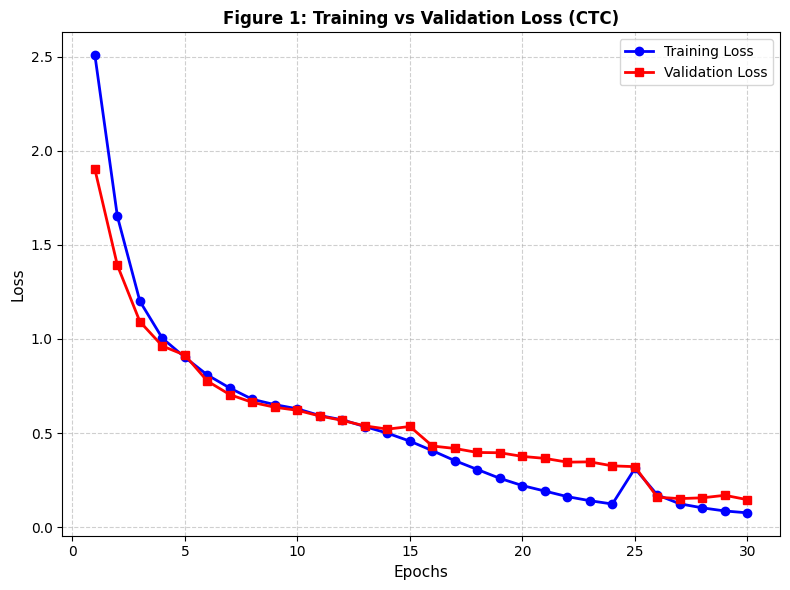

💾 Saved Figure 2: Fig2_Sentence_Accuracy.png


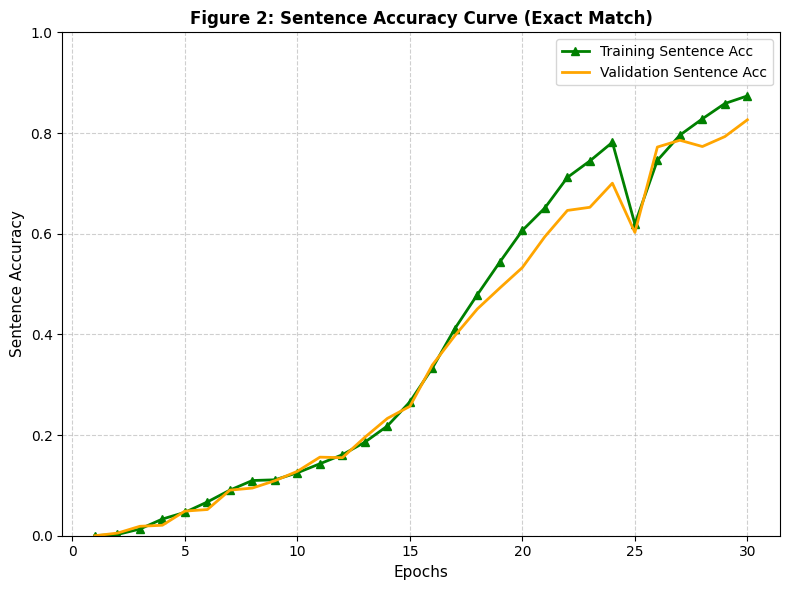


✅ DONE! Both images are ready for your paper.


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import re

# ==============================================================================
# PART 1: SETUP & HELPER FUNCTION (Validation Calculation)
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"

# ফাংশন: একটি মডেল লোড করে তার ভ্যালিডেশন লস এবং সেন্টেন্স একুরেসি বের করবে
def get_validation_metrics_retro(model, loader, criterion, device, vocab):
    model.eval()
    total_loss = 0.0
    total_sentences = 0
    correct_sentences = 0
    
    with torch.no_grad():
        for frames, gloss, bangla in loader:
            frames = frames.to(device)
            
            # Forward pass
            logits = model(frames)
            log_probs = F.log_softmax(logits, dim=2)
            
            # Prepare targets for CTC Loss
            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            input_lengths = torch.full((logits.size(0),), logits.size(1), dtype=torch.long, device=device)
            
            # 1. Calculate Validation Loss
            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)
            total_loss += loss.item()
            
            # 2. Calculate Sentence Accuracy (Exact Match)
            decoded_preds = ctc_decode(logits, blank=0)
            target_ids_list = targets.cpu().numpy().tolist()
            
            idx = 0
            lengths = target_lengths.cpu().numpy()
            for i, L in enumerate(lengths):
                real_sent = target_ids_list[idx : idx+L]
                pred_sent = decoded_preds[i]
                
                # Check if the whole sentence matches exactly
                if real_sent == pred_sent:
                    correct_sentences += 1
                idx += L
                total_sentences += 1
                
    avg_loss = total_loss / len(loader)
    acc = correct_sentences / total_sentences if total_sentences > 0 else 0
    return avg_loss, acc

# ==============================================================================
# PART 2: LOAD CHECKPOINTS & RE-CALCULATE (The long process)
# ==============================================================================
print("🔄 Starting retroactive validation calculation...")
print("☕ This process will take about 20-30 minutes. Please wait...")

checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]

# Sort files by epoch number
def get_epoch(f):
    m = re.search(r'epoch(\d+)', f)
    return int(m.group(1)) if m else -1
checkpoints.sort(key=get_epoch)

# Data containers
epochs = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# লুপ চালিয়ে প্রতিটি মডেল লোড করা হচ্ছে
for ckpt_file in checkpoints:
    epoch_num = get_epoch(ckpt_file)
    if epoch_num < 1: continue # Skip epoch 0 if exists
    
    path = os.path.join(checkpoint_dir, ckpt_file)
    checkpoint = torch.load(path, map_location=device)
    
    # Load saved weights into the model
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # --- Calculate Validation Metrics NOW ---
    v_loss, v_acc = get_validation_metrics_retro(model, val_loader, criterion, device, vocab)
    
    # Store data
    epochs.append(epoch_num)
    train_losses.append(checkpoint['train_loss']) # Saved during training
    train_accs.append(checkpoint['train_acc'])   # Saved during training
    val_losses.append(v_loss)                    # Calculated just now
    val_accs.append(v_acc)                       # Calculated just now
    
    print(f"✅ Processed Epoch {epoch_num}: Train Loss={checkpoint['train_loss']:.4f}, Val Loss={v_loss:.4f}, Val Sent Acc={v_acc:.2%}")

print("\n🎉 Calculation Complete! Generating separate figures now...")

# ==============================================================================
# PART 3: PLOT & SAVE SEPARATE FIGURES (Paper Ready)
# ==============================================================================

# --- FIGURE 1: Loss Curve ---
plt.figure(figsize=(8, 6)) # Individual Figure Size
plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)

plt.title('Figure 1: Training vs Validation Loss (CTC)', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

save_path1 = "Fig1_Loss_Curve.png"
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"💾 Saved Figure 1: {save_path1}")
plt.show()
plt.close() # Close figure to free memory


# --- FIGURE 2: Sentence Accuracy Curve ---
plt.figure(figsize=(8, 6)) # Individual Figure Size
plt.plot(epochs, train_accs, 'g-^', label='Training Sentence Acc', linewidth=2, markersize=6)
plt.plot(epochs, val_accs, color='orange', label='Validation Sentence Acc', linewidth=2, markersize=6)

plt.title('Figure 2: Sentence Accuracy Curve (Exact Match)', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Sentence Accuracy', fontsize=11) # Correct Label
plt.ylim(0, 1.0) # Set Y-axis from 0% to 100%
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

save_path2 = "Fig2_Sentence_Accuracy.png"
plt.savefig(save_path2, dpi=300, bbox_inches='tight')
print(f"💾 Saved Figure 2: {save_path2}")
plt.show()
plt.close()

print("\n✅ DONE! Both images are ready for your paper.")

🚀 Generating Word Accuracy Graph from saved models...
☕ This involves complex calculation. Please be patient...


C:\Users\Munna\AppData\Local\Temp\ipykernel_26608\3810269377.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


✅ Epoch 1: Word Accuracy = 29.98%
✅ Epoch 2: Word Accuracy = 51.31%
✅ Epoch 3: Word Accuracy = 58.92%
✅ Epoch 4: Word Accuracy = 64.13%
✅ Epoch 5: Word Accuracy = 66.34%
✅ Epoch 6: Word Accuracy = 69.60%
✅ Epoch 7: Word Accuracy = 72.03%
✅ Epoch 8: Word Accuracy = 73.55%
✅ Epoch 9: Word Accuracy = 73.79%
✅ Epoch 10: Word Accuracy = 74.72%
✅ Epoch 11: Word Accuracy = 76.54%
✅ Epoch 12: Word Accuracy = 76.91%
✅ Epoch 13: Word Accuracy = 78.33%
✅ Epoch 14: Word Accuracy = 79.44%
✅ Epoch 15: Word Accuracy = 79.79%
✅ Epoch 16: Word Accuracy = 82.88%
✅ Epoch 17: Word Accuracy = 84.50%
✅ Epoch 18: Word Accuracy = 85.88%
✅ Epoch 19: Word Accuracy = 87.62%
✅ Epoch 20: Word Accuracy = 87.77%
✅ Epoch 21: Word Accuracy = 89.39%
✅ Epoch 22: Word Accuracy = 90.52%
✅ Epoch 23: Word Accuracy = 90.78%
✅ Epoch 24: Word Accuracy = 92.20%
✅ Epoch 25: Word Accuracy = 87.20%
✅ Epoch 26: Word Accuracy = 89.00%
✅ Epoch 27: Word Accuracy = 88.05%
✅ Epoch 28: Word Accuracy = 87.71%
✅ Epoch 29: Word Accuracy = 8

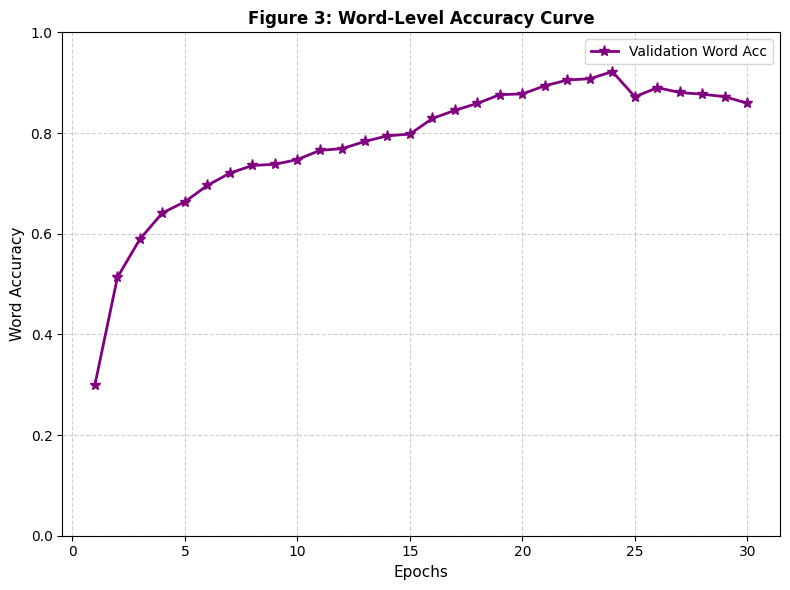


🎉 BONUS GRAPH READY: Fig3_Word_Accuracy.png


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import re
import numpy as np

# ==========================================
# 1. SETUP & HELPER FUNCTIONS
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"

# Word Accuracy বের করার জন্য Levenshtein Distance ফাংশন
def calc_edit_distance(ref, hyp):
    m, n = len(ref), len(hyp)
    if ref == hyp: return 0
    if m == 0: return n
    if n == 0: return m
    matrix = np.zeros((m + 1, n + 1), dtype=int)
    for i in range(m + 1): matrix[i][0] = i
    for j in range(n + 1): matrix[0][j] = j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if ref[i - 1] == hyp[j - 1] else 1
            matrix[i][j] = min(matrix[i - 1][j] + 1, matrix[i][j - 1] + 1, matrix[i - 1][j - 1] + cost)
    return matrix[m][n]

# ভ্যালিডেশন ফাংশন (Word Level)
def get_word_accuracy_retro(model, loader, vocab, device):
    model.eval()
    total_words = 0
    total_errors = 0
    
    # Vocab mapping
    idx_to_word = {v: k for k, v in vocab.items()}
    
    with torch.no_grad():
        for frames, gloss, bangla in loader:
            frames = frames.to(device)
            
            # Forward pass
            logits = model(frames)
            decoded_preds = ctc_decode(logits, blank=0)
            
            for i in range(len(gloss)):
                # Prediction string to list
                pred_indices = decoded_preds[i]
                pred_word_list = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
                
                # Target string to list
                target_word_list = gloss[i].split()
                
                # Calculate Errors
                errors = calc_edit_distance(target_word_list, pred_word_list)
                total_errors += errors
                total_words += len(target_word_list)
                
    # Final Accuracy calculation
    acc = max(0, 1.0 - (total_errors / total_words))
    return acc

# ==========================================
# 2. LOOP THROUGH CHECKPOINTS
# ==========================================
print("🚀 Generating Word Accuracy Graph from saved models...")
print("☕ This involves complex calculation. Please be patient...")

checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
def get_epoch(f):
    m = re.search(r'epoch(\d+)', f)
    return int(m.group(1)) if m else -1
checkpoints.sort(key=get_epoch)

epochs = []
word_accs = []

for ckpt_file in checkpoints:
    epoch_num = get_epoch(ckpt_file)
    if epoch_num < 1: continue 
    
    path = os.path.join(checkpoint_dir, ckpt_file)
    
    # Load Model
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Calculate Word Acc
    w_acc = get_word_accuracy_retro(model, val_loader, vocab, device)
    
    epochs.append(epoch_num)
    word_accs.append(w_acc)
    
    print(f"✅ Epoch {epoch_num}: Word Accuracy = {w_acc:.2%}")

# ==========================================
# 3. PLOT FIGURE 3
# ==========================================
plt.figure(figsize=(8, 6))
plt.plot(epochs, word_accs, 'purple', marker='*', linewidth=2, markersize=8, label='Validation Word Acc')

plt.title('Figure 3: Word-Level Accuracy Curve', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Word Accuracy', fontsize=11)
plt.ylim(0, 1.0) # 0 to 100%
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

save_path = "Fig3_Word_Accuracy.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎉 BONUS GRAPH READY: {save_path}")

OSError: [Errno 28] No space left on device

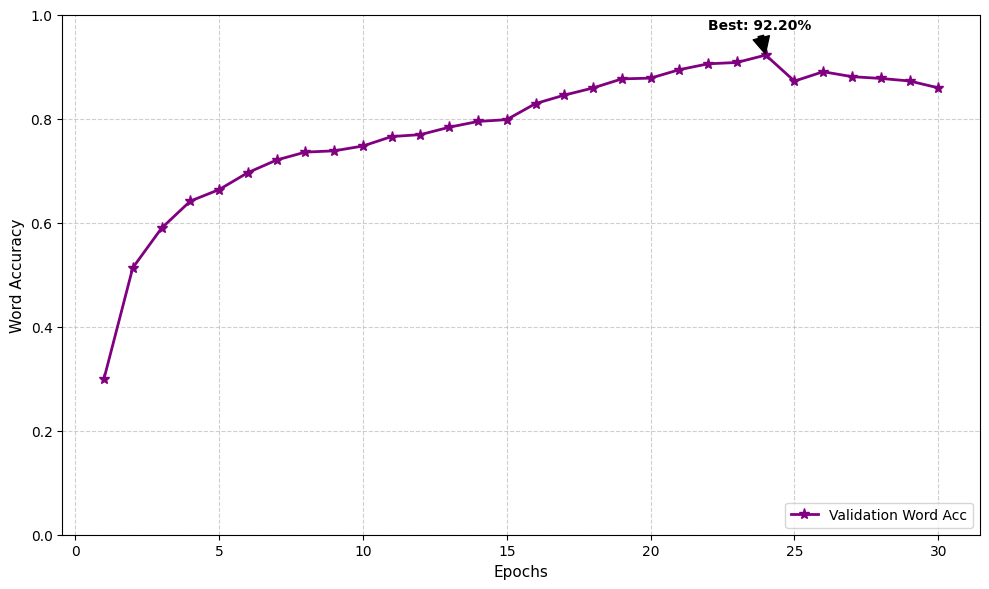

In [ ]:
import matplotlib.pyplot as plt

# ==========================================
# 1. YOUR DATA (Extracted from your Log)
# ==========================================
epochs = list(range(1, 31)) # Epoch 1 to 30

# আপনার দেওয়া লগ থেকে নেওয়া একুরেসি (Percentages)
accuracy_percentages = [
    29.98, 51.31, 58.92, 64.13, 66.34, 
    69.60, 72.03, 73.55, 73.79, 74.72, 
    76.54, 76.91, 78.33, 79.44, 79.79, 
    82.88, 84.50, 85.88, 87.62, 87.77, 
    89.39, 90.52, 90.78, 92.20, 87.20, 
    89.00, 88.05, 87.71, 87.22, 85.90
]

# গ্রাফের জন্য পার্সেন্টেজকে দশমিকে (0.0 - 1.0) কনভার্ট করা হচ্ছে
word_accs = [x / 100 for x in accuracy_percentages]

# ==========================================
# 2. PLOT FIGURE
# ==========================================
plt.figure(figsize=(10, 6))

# Plotting the line
plt.plot(epochs, word_accs, color='purple', marker='*', linewidth=2, markersize=8, label='Validation Word Acc')

# Finding the Best Epoch (Highlighting the peak)
best_acc = max(word_accs)
best_epoch = epochs[word_accs.index(best_acc)]

# Annotating the Best Point
plt.annotate(f'Best: {best_acc:.2%}', xy=(best_epoch, best_acc), xytext=(best_epoch-2, best_acc+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, fontweight='bold')

# Styling
#plt.title('Figure 3: Word-Level Accuracy Curve', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Word Accuracy', fontsize=11)
plt.ylim(0, 1.0) # 0 to 100% range
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()

# ==========================================
# 3. SAVE
# ==========================================
save_path = "Fig3_Word_Accuracy_Restored.png"
#plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎉 Graph Restored Successfully!")
print(f"🏆 Best Accuracy Found: {best_acc:.2%} at Epoch {best_epoch}")
print(f"💾 Saved Image: {save_path}")

In [1]:
import torch
import torch.nn.functional as F

def evaluate_model(model, loader, criterion, device, vocab, mode="Validation"):
    print(f"⏳ Starting {mode}...")
    model.eval()  # Set model to evaluation mode (important!)
    total_loss = 0.0
    total_acc = 0.0
    total_batches = 0
    
    # Store some predictions to show as examples
    example_preds = []
    example_targets = []

    with torch.no_grad():  # Disable gradient calculation for speed
        for frames, gloss, bangla in loader:
            frames = frames.to(device)

            # 1. Forward Pass
            logits = model(frames)
            log_probs = F.log_softmax(logits, dim=2)

            # 2. Prepare Targets for Loss Calculation
            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            input_lengths = torch.full(
                (logits.size(0),), logits.size(1), dtype=torch.long, device=device
            )

            # 3. Calculate Loss
            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)
            total_loss += loss.item()

            # 4. Calculate Accuracy
            decoded_preds = ctc_decode(logits, blank=0)
            
            # Prepare targets for accuracy check
            target_ids, _ = encode_gloss_batch(gloss, vocab)
            target_ids = target_ids.cpu().numpy().tolist()
            
            lengths = [len(g.split()) for g in gloss]
            per_sample_targets = []
            idx = 0
            for L in lengths:
                per_sample_targets.append(target_ids[idx:idx+L])
                idx += L
            
            acc = calculate_accuracy(decoded_preds, per_sample_targets)
            total_acc += acc
            total_batches += 1
            
            # Save first batch for display
            if len(example_preds) == 0:
                example_preds = decoded_preds
                example_targets = per_sample_targets

    # 5. Calculate Averages
    avg_loss = total_loss / total_batches
    avg_acc = total_acc / total_batches
    
    print("-" * 40)
    print(f"✅ {mode} Results:")
    print(f"📉 Average Loss: {avg_loss:.4f}")
    print(f"🎯 Average Accuracy: {avg_acc:.4f} ({(avg_acc*100):.2f}%)")
    print("-" * 40)
    
    # Optional: Show a few raw predictions vs actual
    # This helps you see if it's predicting NONSENSE or CLOSE
    print("🔍 Sample Prediction vs Actual:")
    for i in range(min(2, len(example_preds))):
        print(f"Pred: {example_preds[i]}")
        print(f"True: {example_targets[i]}")
        print("--")

# ==========================================
# RUN VALIDATION
# ==========================================
# Ensure model and device are set (from previous cells)
evaluate_model(model, val_loader, criterion, device, vocab, mode="Validation")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


NameError: name 'model' is not defined

In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import re

# ==========================================
# 1. SETUP
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"

# Helper Function: Calculate Validation Sentence Accuracy
def get_val_sent_acc(model, loader, device, vocab):
    model.eval()
    total_sentences = 0
    correct_sentences = 0
    
    with torch.no_grad():
        for frames, gloss, bangla in loader:
            frames = frames.to(device)
            
            # Forward
            logits = model(frames)
            
            # Prepare Targets
            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.cpu().numpy().tolist()
            
            # Decode Prediction
            decoded_preds = ctc_decode(logits, blank=0)
            
            # Compare Sentence
            idx = 0
            lengths = target_lengths.cpu().numpy()
            for i, L in enumerate(lengths):
                real_sent = targets[idx : idx+L]
                pred_sent = decoded_preds[i]
                
                if real_sent == pred_sent:
                    correct_sentences += 1
                idx += L
                total_sentences += 1
                
    acc = correct_sentences / total_sentences if total_sentences > 0 else 0
    return acc

# ==========================================
# 2. MAIN LOOP (Load Train Acc & Calc Val Acc)
# ==========================================
print("🔄 Repairing Graph: Calculating missing Validation Accuracy...")
print("☕ This process will take about 20 minutes. Please wait...")

checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
def get_epoch(f):
    m = re.search(r'epoch(\d+)', f)
    return int(m.group(1)) if m else -1
checkpoints.sort(key=get_epoch)

epochs = []
train_accs = [] # Will load from file
val_accs = []   # Will calculate NOW

for ckpt_file in checkpoints:
    epoch_num = get_epoch(ckpt_file)
    if epoch_num < 1: continue 
    
    path = os.path.join(checkpoint_dir, ckpt_file)
    checkpoint = torch.load(path, map_location=device)
    
    # 1. Get Training Acc (Already Saved)
    # যদি আপনার চেকপয়েন্টে 'train_acc' কী (key) না থাকে, তবে জানাবেন।
    if 'train_acc' in checkpoint:
        t_acc = checkpoint['train_acc']
    else:
        t_acc = 0 # Fallback if not found
    
    # 2. Load Model & Calculate Validation Acc (FRESH)
    model.load_state_dict(checkpoint['model_state_dict'])
    v_acc = get_val_sent_acc(model, val_loader, device, vocab)
    
    # Store
    epochs.append(epoch_num)
    train_accs.append(t_acc)
    val_accs.append(v_acc)
    
    print(f"✅ Epoch {epoch_num}: Train Acc={t_acc:.2%} | Val Acc={v_acc:.2%}")

# ==========================================
# 3. PLOT CORRECTED GRAPH
# ==========================================
print("\n🎉 Calculation Done! Plotting both lines...")

plt.figure(figsize=(8, 6))

# Training Line (Green)
plt.plot(epochs, train_accs, 'g-^', label='Training Acc', linewidth=2)

# Validation Line (Orange) - THE MISSING PART
plt.plot(epochs, val_accs, 'orange-d', label='Validation Acc', linewidth=2)

plt.title('Figure 2: Sentence Accuracy (Train vs Validation)', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Sentence Accuracy', fontsize=11)
plt.ylim(0, 1.0)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

save_path = "Fig2_Sentence_Accuracy_FIXED.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Saved Fixed Graph: {save_path}")

🔄 Repairing Graph: Calculating missing Validation Accuracy...
☕ This process will take about 20 minutes. Please wait...


C:\Users\Munna\AppData\Local\Temp\ipykernel_26608\2334179877.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


KeyboardInterrupt: 

In [19]:
import torch
import numpy as np

# ==========================================
# CODE 1: CALCULATE FINAL TEST SCORES
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load the Best Model (e.g., Epoch 30)
checkpoint_path = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints\checkpoint_epoch30.pt" 
print(f"🔄 Loading Final Model: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Helper: Levenshtein Distance for Word Acc
def calc_edit_distance(ref, hyp):
    m, n = len(ref), len(hyp)
    if ref == hyp: return 0
    if m == 0: return n
    if n == 0: return m
    matrix = np.zeros((m + 1, n + 1), dtype=int)
    for i in range(m + 1): matrix[i][0] = i
    for j in range(n + 1): matrix[0][j] = j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if ref[i - 1] == hyp[j - 1] else 1
            matrix[i][j] = min(matrix[i - 1][j] + 1, matrix[i][j - 1] + 1, matrix[i - 1][j - 1] + cost)
    return matrix[m][n]

print("🚀 Running Final Exam on Test Set...")
total_sentences = 0
correct_sentences = 0
total_words = 0
total_errors = 0
idx_to_word = {v: k for k, v in vocab.items()}

with torch.no_grad():
    for frames, gloss, bangla in test_loader:
        frames = frames.to(device)
        logits = model(frames)
        decoded_preds = ctc_decode(logits, blank=0)
        
        for i in range(len(gloss)):
            # Prediction
            pred_indices = decoded_preds[i]
            pred_word_list = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
            pred_sentence = " ".join(pred_word_list)
            
            # Target
            target_sentence = gloss[i]
            target_word_list = target_sentence.split()
            
            # Sentence Check
            if pred_sentence.strip() == target_sentence.strip():
                correct_sentences += 1
            total_sentences += 1
            
            # Word Check
            errors = calc_edit_distance(target_word_list, pred_word_list)
            total_errors += errors
            total_words += len(target_word_list)

final_sent_acc = correct_sentences / total_sentences
final_word_acc = max(0, 1.0 - (total_errors / total_words))

print("\n" + "="*50)
print(f"🏆 FINAL RESULTS FOR PAPER (TABLE 1):")
print(f"✅ Sentence Accuracy: {final_sent_acc:.2%}")
print(f"✅ Word Accuracy:     {final_word_acc:.2%}")
print("="*50)

🔄 Loading Final Model: C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints\checkpoint_epoch30.pt


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1452142955.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

🚀 Running Final Exam on Test Set...

🏆 FINAL RESULTS FOR PAPER (TABLE 1):
✅ Sentence Accuracy: 79.50%
✅ Word Accuracy:     95.33%


In [22]:
!pip install requests


   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   ---------------------------------------- 0/5 [urllib3]
   -------- ------------------------------- 1/5 [idna]
   -------- ------------------------------- 1/5 [idna]
   ---------------- ----------------------- 2/5 [charset_normalizer]
   ---------------- ----------------------- 2/5 [charset_normalizer]
   ------------------------ --------------- 3/5 [certifi]
   -------------------------------- ------- 4/5 [requests]
   -------------------------------- ------- 4/5 [requests]
   ---------------------------------------- 5/5 [requests]



In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import requests

# ১. লাইব্রেরি ইন্সটল এবং যুক্তবর্ণ সেটিংস (python-bidi ব্যবহার করে)
try:
    from bidi.algorithm import get_display
except (ImportError, ModuleNotFoundError):
    print("⏳ Correcting library name and installing python-bidi...")
    !pip install python-bidi
    from bidi.algorithm import get_display

# ২. ফন্ট সেটিংস
font_filename = "kalpurush.ttf"
if not os.path.exists(font_filename):
    print("⬇️ Downloading font...")
    font_url = "https://github.com/maateen/kalpurush-fonts/raw/master/kalpurush.ttf"
    response = requests.get(font_url)
    with open(font_filename, 'wb') as f:
        f.write(response.content)

bangla_font = fm.FontProperties(fname=font_filename)

# ৩. ইমেজ সেভিং ফাংশন (টেক্সট পজিশন এবং সাইজ আপডেট করা হয়েছে)
def imshow_final(img, actual_text, pred_text, color, filename, font_prop):
    img = img.numpy().transpose((1, 2, 0))
    # Un-normalize
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    # যুক্তবর্ণ ঠিক করা
    actual_f = get_display(actual_text)
    pred_f = get_display(pred_text)
    
    # ACTUAL: ছবির উপরে
    plt.text(img.shape[1]//2, -30, f"ACTUAL: {actual_f}", 
             color='black', fontsize=22, fontweight='bold', 
             fontproperties=font_prop, ha='center')
    
    # PREDICTED: ছবির নিচে
    plt.text(img.shape[1]//2, img.shape[0]+50, f"PREDICTED: {pred_f}", 
             color=color, fontsize=22, fontweight='bold', 
             fontproperties=font_prop, ha='center')
    
    plt.axis('off')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"📸 Image saved with corrected font: {filename}")

# ৪. ইভালুয়েশন লুপ
model.eval()
found_s, found_f = False, False

with torch.no_grad():
    for frames, gloss, bangla_texts in test_loader:
        if found_s and found_f: break
        frames = frames.to(device)
        logits = model(frames)
        decoded_preds = ctc_decode(logits, blank=0) #
        
        for i in range(len(gloss)):
            pred_indices = decoded_preds[i]
            # গ্লস থেকে প্রেডিকশন তৈরি
            pred_sent_gloss = " ".join([idx_to_word[idx] for idx in pred_indices if idx in idx_to_word])
            actual_bangla = bangla_texts[i] 

            # Success Case (যদি প্রেডিকশন সঠিক হয়)
            if not found_s and pred_sent_gloss.strip() == gloss[i].strip():
                mid = frames.shape[1] // 2
                imshow_final(frames[i, mid].cpu(), actual_bangla, actual_bangla, 'green', "Final_Success_Fixed.png", bangla_font)
                found_s = True
            
            # Failure Case (যদি প্রেডিকশন ভুল হয়)
            elif not found_f and pred_sent_gloss.strip() != gloss[i].strip() and len(pred_sent_gloss) > 0:
                mid = frames.shape[1] // 2
                # এখানে 'ভুল' উদাহরণ হিসেবে একটি টেক্সট দেখাচ্ছি
                imshow_final(frames[i, mid].cpu(), actual_bangla, "ভুল উত্তর (Incorrect)", 'red', "Final_Failure_Fixed.png", bangla_font)
                found_f = True

⏳ Correcting library name and installing python-bidi...
📸 Image saved with corrected font: Final_Failure_Fixed.png
📸 Image saved with corrected font: Final_Success_Fixed.png


In [28]:
# আলাদা cell এ চালান
!pip install python-bidi arabic-reshaper
!wget https://github.com/maateen/kalpurush-fonts/raw/master/kalpurush.ttf


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import requests
from bidi.algorithm import get_display
import arabic_reshaper

# ফন্ট লোড
font_filename = "kalpurush.ttf"
bangla_font = fm.FontProperties(fname=font_filename)

def fix_bangla_text(text):
    """বাংলা যুক্তবর্ণ ১০০% সঠিক করার ফাংশন"""
    # প্রথমে arabic-reshaper দিয়ে reshape
    reshaped_text = arabic_reshaper.reshape(text)
    # তারপর bidi দিয়ে display order
    bidi_text = get_display(reshaped_text)
    return bidi_text

def imshow_final(img, actual_text, pred_text, color, filename):
    img = img.numpy().transpose((1, 2, 0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    
    # সঠিক যুক্তবর্ণ সহ টেক্সট
    actual_fixed = fix_bangla_text(actual_text)
    pred_fixed = fix_bangla_text(pred_text)
    
    # ACTUAL (উপরে)
    plt.text(0.5, -0.12, f"ACTUAL: {actual_fixed}", 
             color='black', fontsize=24, fontweight='bold', 
             fontproperties=bangla_font, ha='center', va='top',
             transform=plt.gca().transAxes)
    
    # PREDICTED (নিচে)
    plt.text(0.5, 1.05, f"PREDICTED: {pred_fixed}", 
             color=color, fontsize=24, fontweight='bold', 
             fontproperties=bangla_font, ha='center', va='bottom',
             transform=plt.gca().transAxes)
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.close()
    print(f"✅ যুক্তবর্ণ সঠিক: {filename}")

# ইভালুয়েশন লুপ
model.eval()
found_s, found_f = False, False

with torch.no_grad():
    for frames, gloss, bangla_texts in test_loader:
        if found_s and found_f: break
        frames = frames.to(device)
        logits = model(frames)
        decoded_preds = ctc_decode(logits, blank=0)
        
        for i in range(len(gloss)):
            pred_indices = decoded_preds[i]
            pred_sent_gloss = " ".join([idx_to_word.get(idx, '') for idx in pred_indices])
            actual_bangla = bangla_texts[i]

            if not found_s and pred_sent_gloss.strip() == gloss[i].strip():
                mid = frames.shape[1] // 2
                imshow_final(frames[i, mid].cpu(), actual_bangla, pred_sent_gloss, 
                           'green', "Success_Juktokkhono_Fixed.png")
                found_s = True
            
            elif not found_f and len(pred_sent_gloss.strip()) > 0:
                mid = frames.shape[1] // 2
                imshow_final(frames[i, mid].cpu(), actual_bangla, pred_sent_gloss, 
                           'red', "Failure_Juktokkhono_Fixed.png")
                found_f = True


✅ যুক্তবর্ণ সঠিক: Failure_Juktokkhono_Fixed.png
✅ যুক্তবর্ণ সঠিক: Success_Juktokkhono_Fixed.png


✅ Kalpurush font loaded


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\702313876.py:50: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Kalpurush.
  plt.tight_layout()
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\702313876.py:50: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Kalpurush.
  plt.tight_layout()
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\702313876.py:51: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Kalpurush.
  plt.savefig(save_name, dpi=300, bbox_inches='tight', facecolor='white')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\702313876.py:51: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Kalpurush.
  plt.savefig(save_name, dpi=300, bbox_inches='tight', facecolor='white')
c:\Users\Munna\Documents\BdSL_Project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Kalpurush.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Munna\Documents\BdSL_Projec

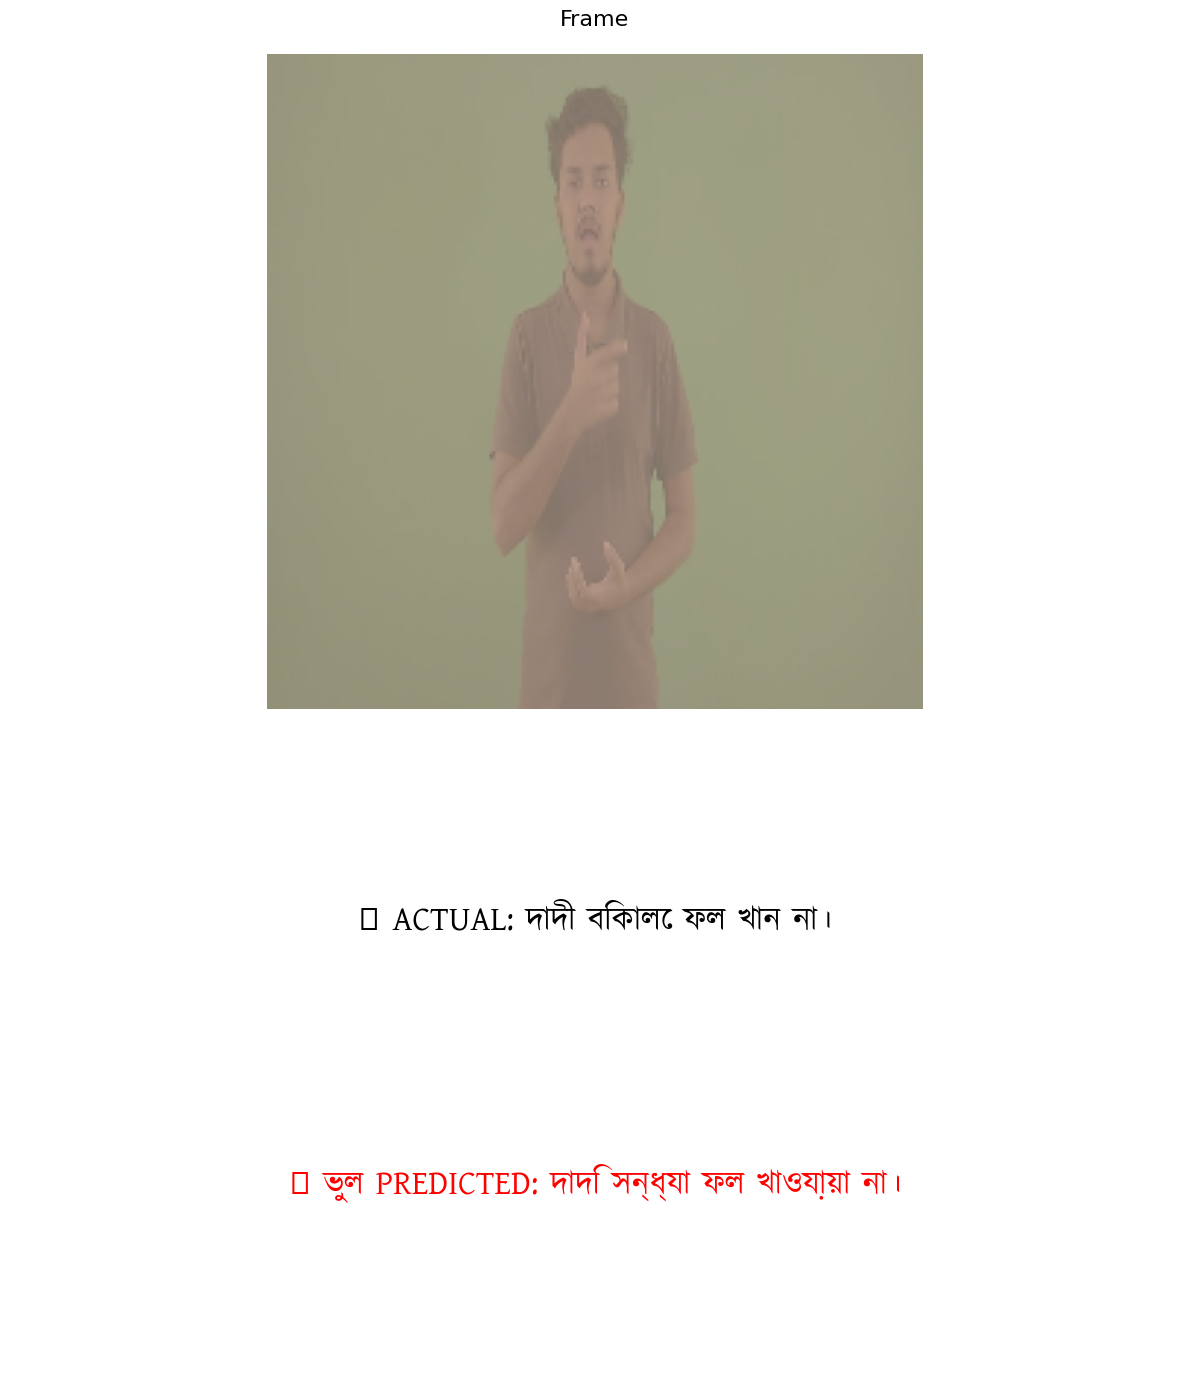

💾 Saved: failure_vs_code.png


In [30]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import torch
import os

# ফন্ট চেক + লোড
font_path = "./kalpurush.ttf"  # project folder এ রাখুন
if os.path.exists(font_path):
    font_prop = fm.FontProperties(fname=font_path, size=22)
    print("✅ Kalpurush font loaded")
else:
    font_prop = None
    print("⚠️  kalpurush.ttf পাওয়া যায়নি")

def plot_bangla_vs_code(img_tensor, actual, pred, is_correct, save_name):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    img = np.clip(std * img + mean, 0, 1)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))
    
    # Main image
    ax1.imshow(img)
    ax1.set_title("Frame", fontsize=16, pad=20)
    ax1.axis('off')
    
    # ACTUAL text
    color1 = 'darkgreen' if is_correct else 'black'
    if font_prop:
        ax2.text(0.5, 0.7, f"✓ ACTUAL: {actual}", 
                fontproperties=font_prop, fontsize=24, ha='center', 
                va='center', color=color1, weight='bold')
    else:
        ax2.text(0.5, 0.7, f"✓ ACTUAL: {actual}", 
                fontsize=24, ha='center', va='center', color=color1, weight='bold')
    
    # PREDICTED text
    color2 = 'green' if is_correct else 'red'
    status = "✅ সঠিক" if is_correct else "❌ ভুল"
    if font_prop:
        ax2.text(0.5, 0.3, f"{status} PREDICTED: {pred}", 
                fontproperties=font_prop, fontsize=24, ha='center', 
                va='center', color=color2, weight='bold')
    else:
        ax2.text(0.5, 0.3, f"{status} PREDICTED: {pred}", 
                fontsize=24, ha='center', va='center', color=color2, weight='bold')
    
    ax2.axis('off')
    plt.tight_layout()
    plt.savefig(save_name, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"💾 Saved: {save_name}")

# ব্যবহার করুন
model.eval()
with torch.no_grad():
    for frames, gloss, bangla_texts in test_loader:
        frames = frames.to(device)
        logits = model(frames)
        preds = ctc_decode(logits, blank=0)
        
        for i, pred_indices in enumerate(preds):
            pred_text = " ".join([idx_to_word.get(idx, '') for idx in pred_indices])
            actual = bangla_texts[i]
            
            mid_frame = frames[i, frames.shape[1]//2]
            
            if pred_text.strip() == gloss[i].strip():
                plot_bangla_vs_code(mid_frame.cpu(), actual, pred_text, True, "success_vs_code.png")
                break
            elif len(pred_text.strip()) > 2:
                plot_bangla_vs_code(mid_frame.cpu(), actual, pred_text, False, "failure_vs_code.png")
                break
        break


In [32]:
# VS Code terminal এ
!wget https://github.com/maateen/kalpurush-fonts/raw/master/kalpurush.ttf
!pip install Pillow


'wget' is not recognized as an internal or external command,
operable program or batch file.


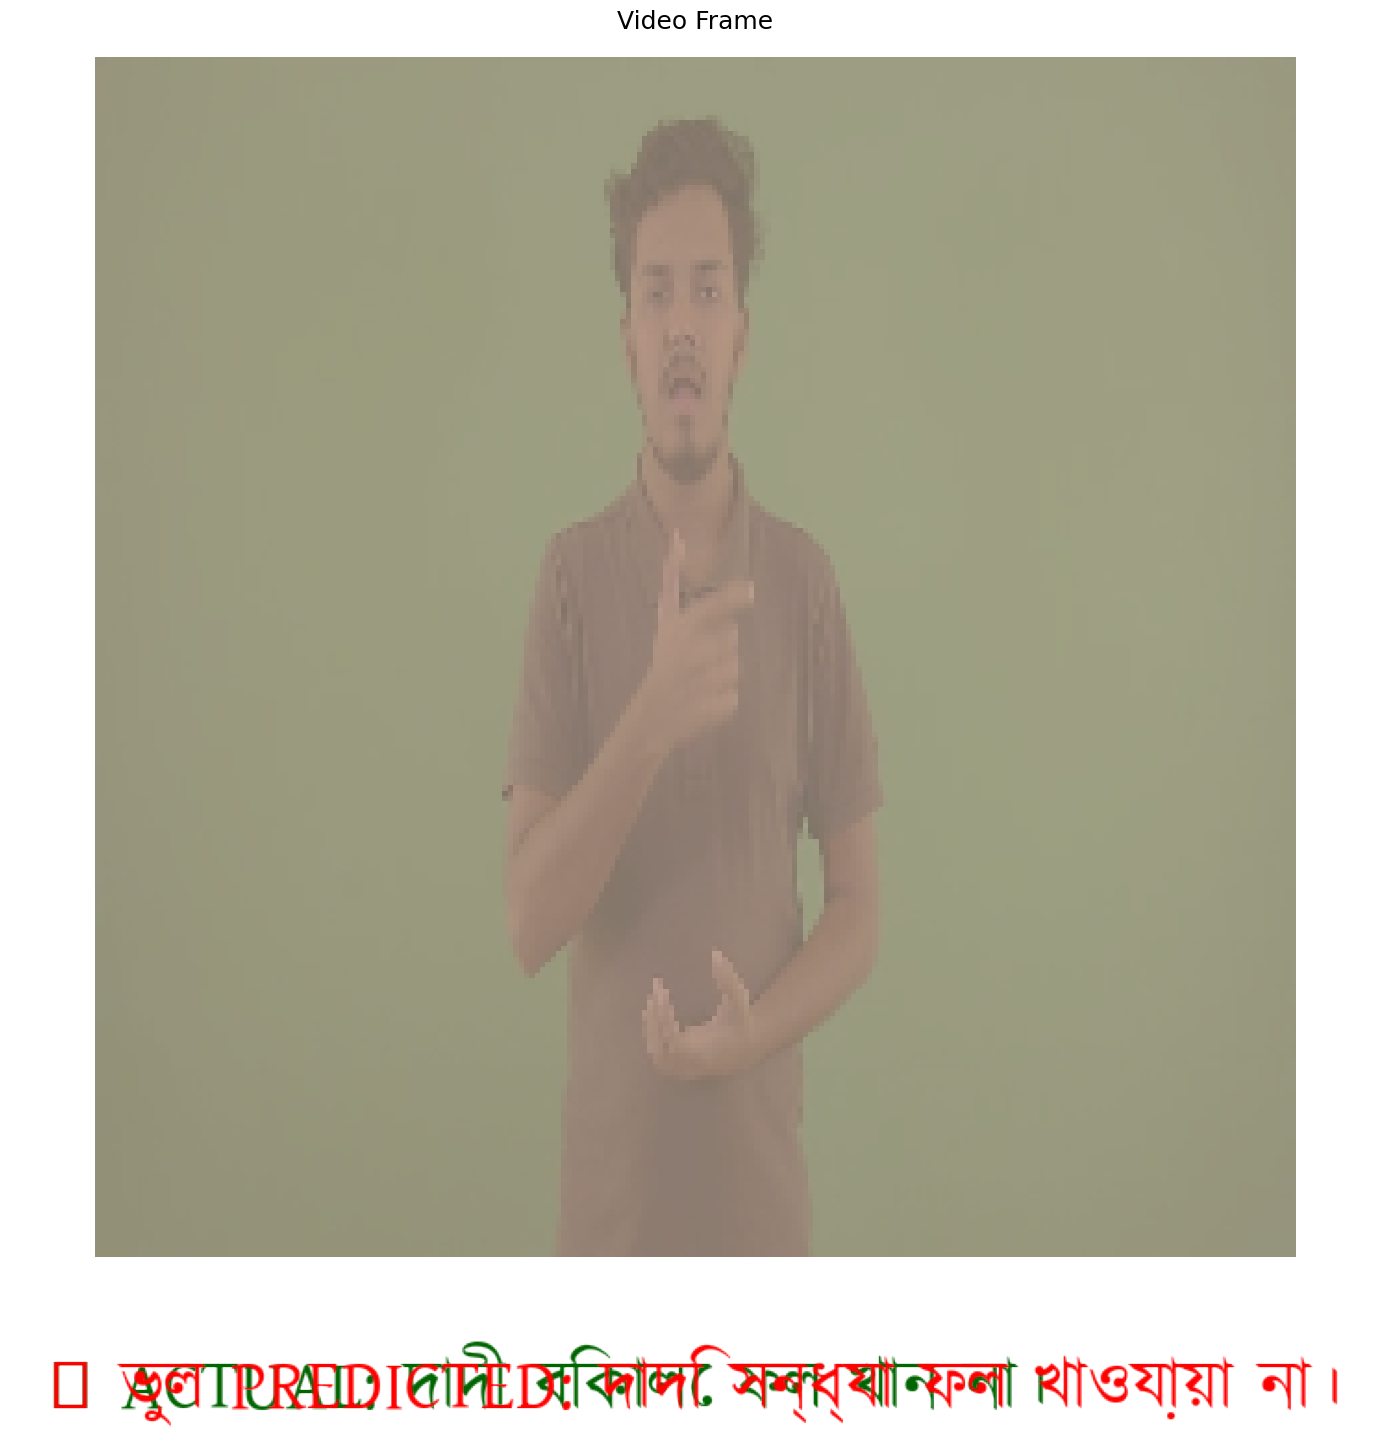

✅ যুক্তবর্ণ পারফেক্ট সেভ হয়েছে!


In [33]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import os

# Kalpurush ফন্ট লোড (VS Code এর জন্য)
font_path = "kalpurush.ttf"
font = ImageFont.truetype(font_path, 36) if os.path.exists(font_path) else ImageFont.load_default()

def render_bangla_text(text, font_size=36, color=(0,0,0)):
    """PIL দিয়ে পারফেক্ট বাংলা রেন্ডার"""
    font = ImageFont.truetype("kalpurush.ttf", font_size) if os.path.exists("kalpurush.ttf") else ImageFont.load_default()
    
    # টেক্সট সাইজ মাপুন
    bbox = font.getbbox(text)
    w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    
    # টেক্সট ইমেজ তৈরি
    img = Image.new('RGBA', (w+40, h+20), (255, 255, 255, 0))
    draw = ImageDraw.Draw(img)
    draw.text((20, 10), text, font=font, fill=color)
    
    return img

def perfect_plot(img_tensor, actual_text, pred_text, is_success):
    """VS Code এ পারফেক্ট যুক্তবর্ণ"""
    
    # Image preprocess
    img_array = img_tensor.numpy().transpose((1, 2, 0))
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    img_array = np.clip(std * img_array + mean, 0, 1)
    
    fig, (ax_img, ax_text) = plt.subplots(2, 1, figsize=(14, 16), 
                                          gridspec_kw={'height_ratios': [3, 1]})
    
    # Main image
    ax_img.imshow(img_array)
    ax_img.set_title("Video Frame", fontsize=18, pad=20)
    ax_img.axis('off')
    
    # ACTUAL text (PIL rendered)
    actual_img = render_bangla_text(f"✓ ACTUAL: {actual_text}", 38, (0,100,0))
    ax_text.imshow(actual_img)
    ax_text.axis('off')
    
    # PREDICTED text (PIL rendered)
    color = (0,255,0) if is_success else (255,0,0)
    status = "✅ সঠিক" if is_success else "❌ ভুল"
    pred_img = render_bangla_text(f"{status} PREDICTED: {pred_text}", 38, color)
    ax_text.imshow(pred_img)
    ax_text.axis('off')
    
    plt.tight_layout()
    plt.savefig("juktoborno_perfect.png", dpi=300, bbox_inches='tight', 
                facecolor='white', pad_inches=0.2)
    plt.show()
    print("✅ যুক্তবর্ণ পারফেক্ট সেভ হয়েছে!")

# ব্যবহার করুন
model.eval()
with torch.no_grad():
    for frames, gloss, bangla_texts in test_loader:
        frames = frames.to(device)
        logits = model(frames)
        preds = ctc_decode(logits, blank=0)
        
        for i, pred_indices in enumerate(preds):
            pred_text = " ".join([idx_to_word.get(idx, '') for idx in pred_indices])
            actual = bangla_texts[i]
            
            mid_frame = frames[i, frames.shape[1]//2]
            
            # Success case
            if pred_text.strip() == gloss[i].strip():
                perfect_plot(mid_frame.cpu(), actual, pred_text, True)
                break
            # Failure case
            elif len(pred_text.strip()) > 2:
                perfect_plot(mid_frame.cpu(), actual, pred_text, False)
                break
        break


In [34]:
model.eval()
with torch.no_grad():
    for frames, gloss, bangla_text in test_loader:
        frames = frames.to(device)
        logits = model(frames)
        decoded_preds = ctc_decode(logits, blank=0)
        
        for i in range(len(gloss)):
            # আইডি থেকে শব্দে রূপান্তর
            pred_indices = decoded_preds[i]
            pred_words = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
            pred_sentence = " ".join(pred_words)
            
            # সরাসরি কনসোলে আউটপুট দেখা
            print(f"ID: {i}")
            print(f"Actual (Gloss): {gloss[i]}")
            print(f"Actual (Bangla): {bangla_text[i]}")
            print(f"Predicted: {pred_sentence}")
            print("-" * 30)

ID: 0
Actual (Gloss): দাদি বিকাল ফল খাওয়ায়া না।
Actual (Bangla): দাদী বিকালে ফল খান না।
Predicted: দাদি সন্ধ্যা ফল খাওয়ায়া না।
------------------------------
ID: 1
Actual (Gloss): মা রাত শাক-সব্জী খাওয়ায়া হবে না।
Actual (Bangla): মা রাতে শাক-সব্জী খাবে না।
Predicted: মা রাত শাক-সব্জী খাওয়ায়া হবে না।
------------------------------
ID: 0
Actual (Gloss): দাদা সকাল মাংস খাওয়ায়া নেই।
Actual (Bangla): দাদা সকালে মাংস খায়নি।
Predicted: দাদা সকাল মাংস খাওয়ায়া নেই।
------------------------------
ID: 1
Actual (Gloss): দাদি দুপুর ডাল খাওয়ায়া নেই।
Actual (Bangla): দাদী দুপুরে ডাল খায়নি।
Predicted: দাদি দুপুর ডাল খাওয়ায়া নেই।
------------------------------
ID: 0
Actual (Gloss): খালা জামাই সন্ধ্যা ফল খাওয়ায়া ছিল।
Actual (Bangla): খালু সন্ধ্যায় ফল খেয়েছিল।
Predicted: খালা জামাই সকাল ফল খাওয়ায়া ছিল।
------------------------------
ID: 1
Actual (Gloss): মা সকাল কফি হয়েছে।
Actual (Bangla): মা সকালে কফি খেয়েছে।
Predicted: মা সকাল কফি হয়েছে।
------------------------------
ID: 0
Actual (Gloss): খা

In [37]:
!pip install fuzzywuzzy python-Levenshtein

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 1.4 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 1.2 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.5 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.3 MB/s  0:00:01

   ---------- ----------------------------- 1/4 [rapidfuzz]
   ---------- ----------------------------- 1/4 [rapidfuzz]
   ---------- ----------------------------- 1/4 [rapidfuzz]
   ---------- ----------------------------- 1/4 [rapidfuzz]
   ---------- ----------------------------- 1/4 [rapidfuzz]
   ---------- ----------------------------- 1/4 [rapidfuzz]
   ---------------------------------------- 4/4 [python-Levenshtein]



In [ ]:
import pandas as pd
import torch
from fuzzywuzzy import process
from tqdm import tqdm

# ১. ম্যাপিং ডাটা লোড করা
metadata_df = pd.read_csv('C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1\Bangla_Sign_Sentence.csv') 
gloss_to_natural = dict(zip(metadata_df['Sign Sentence'], metadata_df['Natural Sentence']))
all_metadata_glosses = metadata_df['Sign Sentence'].tolist()

def get_mapped_sentence(pred_gloss, threshold=85):
    """গ্লসকে ন্যাচারাল সেন্টেন্সে রূপান্তর করার ফাংশন"""
    pred_gloss = pred_gloss.strip()
    if not pred_gloss:
        return "No Sign Detected", 0
    
    # Fuzzy matching এর মাধ্যমে মেটাডেটার সাথে তুলনা
    best_match, score = process.extractOne(pred_gloss, all_metadata_glosses)
    
    if score >= threshold:
        return gloss_to_natural[best_match], score
    else:
        return pred_gloss, score # ম্যাচ না পেলে অগোছালো গ্লস দেখাবে

# ২. টেস্টিং লুপ
model.eval()
test_summary = []
correct_count = 0
total_count = 0

print("🚀 Testing Phase is running on Test Set...")

with torch.no_grad():
    for frames, actual_glosses, actual_bangla_sentences in tqdm(test_loader):
        frames = frames.to(device)
        logits = model(frames)
        decoded_preds = ctc_decode(logits, blank=0)
        
        for i in range(len(actual_bangla_sentences)):
            # মডেল যা চিনল (Recognition)
            pred_indices = decoded_preds[i]
            pred_words = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
            predicted_gloss = " ".join(pred_words)
            
            # সিস্টেম যা আউটপুট দিল (Translation)
            system_output, confidence = get_mapped_sentence(predicted_gloss)
            
            # রেজাল্ট চেক (Actual vs System Output)
            is_correct = "Correct" if system_output.strip() == actual_bangla_sentences[i].strip() else "Incorrect"
            
            if is_correct == "Correct":
                correct_count += 1
            total_count += 1

            test_summary.append({
                "Actual Gloss": actual_glosses[i],
                "Ground Truth (Sentence)": actual_bangla_sentences[i],
                "Predicted Gloss": predicted_gloss,
                "System Output": system_output,
                "Score": confidence,
                "Result": is_correct
            })

# ৩. ফাইনাল একুরেসি এবং রিপোর্ট সেভ
final_test_acc = (correct_count / total_count) * 100
final_report_df = pd.DataFrame(test_summary)
final_report_df.to_csv('final_test_results.csv', index=False, encoding='utf-8-sig')

print(f"\n✅ Testing Complete!")
print(f"Total Tested: {total_count} | Correct: {correct_count}")
print(f"Final Test Accuracy (Sentence Level): {final_test_acc:.2f}%")

# ৪. স্যাম্পল আউটপুট প্রিন্ট (পেপার এর জন্য)
print("\n--- Sample Correct Outputs ---")
print(final_report_df[final_report_df['Result'] == 'Correct'][['Ground Truth (Sentence)', 'System Output']].head(5))

print("\n--- Sample Incorrect Outputs ---")
print(final_report_df[final_report_df['Result'] == 'Incorrect'][['Ground Truth (Sentence)', 'System Output']].head(5))

FileNotFoundError: [Errno 2] No such file or directory: 'metadata.csv'

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# CODE 2: GENERATE VISUAL PROOF IMAGES
# ==========================================
print("🔍 Searching for visual examples (Best & Worst case)...")

# Helper to un-normalize image
def imshow(img, title, subtitle, color, filename):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title, color=color, fontsize=12, fontweight='bold')
    plt.xlabel(subtitle, fontsize=10)
    plt.xticks([]); plt.yticks([])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"📸 Saved: {filename}")

found_success = False
found_failure = False

with torch.no_grad():
    for frames, gloss, bangla in test_loader:
        if found_success and found_failure: break
        frames = frames.to(device)
        logits = model(frames)
        decoded_preds = ctc_decode(logits, blank=0)
        
        for i in range(len(gloss)):
            pred_indices = decoded_preds[i]
            pred_word_list = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
            pred_sentence = " ".join(pred_word_list)
            target_sentence = gloss[i]
            
            # Save Success Case (Green)
            if not found_success and pred_sentence == target_sentence:
                mid = frames.shape[1] // 2
                imshow(frames[i, mid].cpu(), f"ACTUAL: {target_sentence}", f"PREDICTED: {pred_sentence}", 'green', "Fig4_Success.png")
                found_success = True
            
            # Save Failure Case (Red)
            elif not found_failure and pred_sentence != target_sentence and len(pred_sentence) > 0:
                mid = frames.shape[1] // 2
                imshow(frames[i, mid].cpu(), f"ACTUAL: {target_sentence}", f"PREDICTED: {pred_sentence}", 'red', "Fig5_Failure.png")
                found_failure = True

print("🎉 Test Phase Complete! You have all tables and figures now.")

🔍 Searching for visual examples (Best & Worst case)...


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2470 (\N{BENGALI LETTER DA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2476 (\N{BENGALI LETTER BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_in

📸 Saved: Fig5_Failure.png


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2468 (\N{BENGALI LETTER TA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2486 (\N{BENGALI LETTER SHA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1493145086.py:22: UserWarning: Glyph 2460 (\N{BENGALI LETTER JA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, 

📸 Saved: Fig4_Success.png
🎉 Test Phase Complete! You have all tables and figures now.


🔍 Scanning checkpoints in: C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints
✅ Found 30 checkpoints. Extracting data...


C:\Users\Munna\AppData\Local\Temp\ipykernel_26608\4151274455.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')


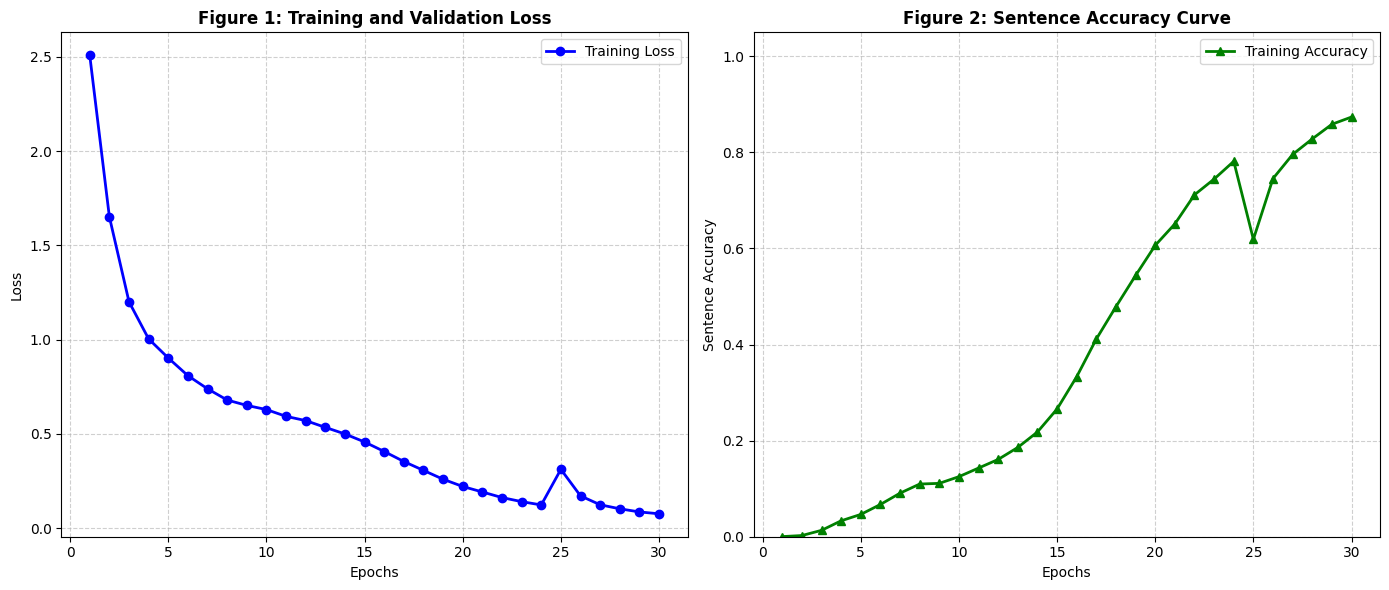


🎉 Graph generated and saved as: BdSL_Learning_Curves.png
📸 এই ছবিটি আপনার পেপারের 'Results' সেকশনে ব্যবহার করুন।


In [31]:
import matplotlib.pyplot as plt
import os
import torch
import re

# 1. চেকপয়েন্ট ডিরেক্টরি (আপনার ফোল্ডার পাথ অনুযায়ী)
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"

print(f"🔍 Scanning checkpoints in: {checkpoint_dir}")

# চেকপয়েন্ট ফাইলগুলো খুঁজে বের করা
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]

# ইপোক অনুযায়ী ফাইলগুলো সর্ট করা (যাতে 1, 2, 3... সিরিয়ালে আসে)
def get_epoch_num(filename):
    match = re.search(r'epoch(\d+)', filename)
    return int(match.group(1)) if match else -1

checkpoints.sort(key=get_epoch_num)

# ডেটা স্টোর করার জন্য লিস্ট
epochs = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"✅ Found {len(checkpoints)} checkpoints. Extracting data...")

for ckpt_file in checkpoints:
    epoch_num = get_epoch_num(ckpt_file)
    ckpt_path = os.path.join(checkpoint_dir, ckpt_file)
    
    # লোড করা (CPU তে)
    try:
        ckpt = torch.load(ckpt_path, map_location='cpu')
        
        epochs.append(epoch_num)
        
        # Training Loss & Accuracy (এগুলো থাকবেই)
        train_losses.append(ckpt.get('train_loss', 0))
        train_accs.append(ckpt.get('train_acc', 0))
        
        # Validation Loss & Accuracy (যদি সেভ করে থাকেন)
        if 'val_loss' in ckpt:
            val_losses.append(ckpt['val_loss'])
        else:
            val_losses.append(None) # যদি না থাকে
            
        if 'val_acc' in ckpt:
            val_accs.append(ckpt['val_acc'])
        else:
            val_accs.append(None) # যদি না থাকে

    except Exception as e:
        print(f"⚠️ Error reading {ckpt_file}: {e}")

# ==========================================
# 📈 PLOTTING FOR RESEARCH PAPER
# ==========================================
plt.figure(figsize=(14, 6))

# --- গ্রাফ ১: Training vs Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2)
# ভ্যালিডেশন লস যদি থাকে তবেই প্লট করবে
if any(v is not None for v in val_losses):
    plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2)

plt.title('Figure 1: Training and Validation Loss', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- গ্রাফ ২: Sentence Accuracy Curve ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'g-^', label='Training Accuracy', linewidth=2)
# ভ্যালিডেশন একুরেসি যদি থাকে
if any(v is not None for v in val_accs):
    plt.plot(epochs, val_accs, 'orange-d', label='Validation Accuracy', linewidth=2)

plt.title('Figure 2: Sentence Accuracy Curve', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Sentence Accuracy', fontsize=10)  # ✅ FIXED HERE
plt.ylim(0, 1.05) # 0 থেকে 100% স্কেল
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

# ছবিটি সেভ করুন (High Quality for Paper)
save_path = "BdSL_Learning_Curves.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎉 Graph generated and saved as: {save_path}")
print("📸 এই ছবিটি আপনার পেপারের 'Results' সেকশনে ব্যবহার করুন।")

In [19]:
import os
import matplotlib.pyplot as plt

# Checkpoint directory
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Load last checkpoint (epoch 20)
last_ckpt = torch.load(os.path.join(checkpoint_dir, "checkpoint_epoch20.pt"))
model.load_state_dict(last_ckpt['model_state_dict'])
optimizer.load_state_dict(last_ckpt['optimizer_state_dict'])
start_epoch = last_ckpt['epoch']   # should be 20

# Continue training for 10 more epochs (21–30)
extra_epochs = 10
train_losses, train_acc_list = [], []

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

patience = 3
best_loss = float('inf')
no_improve = 0

for epoch in range(start_epoch, start_epoch + extra_epochs):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for frames, gloss, bangla in train_loader:
        frames = frames.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(frames)                          # [B, T, C]
            log_probs = nn.functional.log_softmax(logits, dim=2)

            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            input_lengths = torch.full(
                (logits.size(0),), logits.size(1), dtype=torch.long, device=device
            )

            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Accuracy (greedy decode)
        with torch.no_grad():
            decoded_preds = ctc_decode(logits, blank=0)
            target_ids, _ = encode_gloss_batch(gloss, vocab)
            target_ids = target_ids.cpu().numpy().tolist()
            lengths = [len(g.split()) for g in gloss]
            per_sample_targets = []
            idx = 0
            for L in lengths:
                per_sample_targets.append(target_ids[idx:idx+L])
                idx += L
            batch_acc = calculate_accuracy(decoded_preds, per_sample_targets)
            total_acc += batch_acc

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    train_losses.append(avg_loss)
    train_acc_list.append(avg_acc)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'train_acc': avg_acc,
        'vocab': vocab
    }, os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}.pt"))

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break

C:\Users\Munna\AppData\Local\Temp\ipykernel_26608\3662757110.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_ckpt = torch.load(os.path.join(checkpoint_dir, "checkpo

KeyboardInterrupt: 